# Run inference on deployed endpoint

In this notebook, I deploy an endpoint from a previously trained model.
I send test CT scans, visualize

## Deploy the endpoint

In [1]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
sess = sagemaker.Session()
bucket = sess.default_bucket()

In [3]:
model = PyTorchModel(
    image_uri="971422676823.dkr.ecr.us-east-1.amazonaws.com/ct-images-segmentation-inference:latest",
    model_data=f"s3://{bucket}/training_jobs/fpn-with-focal-loss-b1-2025-06-27-13-36-34-606/output/model.tar.gz",
    role=sagemaker.get_execution_role(),
    entry_point="inference.py",
    source_dir="../src",
)

In [ ]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.2xlarge"
)

----

In [18]:
print(f"The deployed endpoint name is: {predictor.endpoint_name}")

The deployed endpoint name is: ct-images-segmentation-inference-2025-06-28-22-46-22-756


## Send test data to endpoint and get the predictions

In [19]:
import io

import numpy as np

In [20]:
def array_to_bytes(array):
    buf = io.BytesIO()
    np.save(buf, array)
    buf.seek(0)
    return buf

In [21]:
test_images = np.load("processed/test/images.npy")

In [22]:
responses = []
for idx in range(len(test_images)):
    response = predictor.predict(
        array_to_bytes(test_images[idx]),
        initial_args={"ContentType": "application/x-npy"}
    )
    responses.append(response)

In [23]:
preds = np.concatenate(responses, axis=0)

### Visualize test predictions

In [24]:
import matplotlib.pyplot as plt

def visualize_batch(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(
        num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2)
    )

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i, :, :, 0], cmap="Greys")
        ax_image.set_xticks([])
        ax_image.set_yticks([])

        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i, :, :, j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3))
                    mask_to_show[..., 0] = pred_batch[i, :, :, j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i, :, :, j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([])
                ax[j + 1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

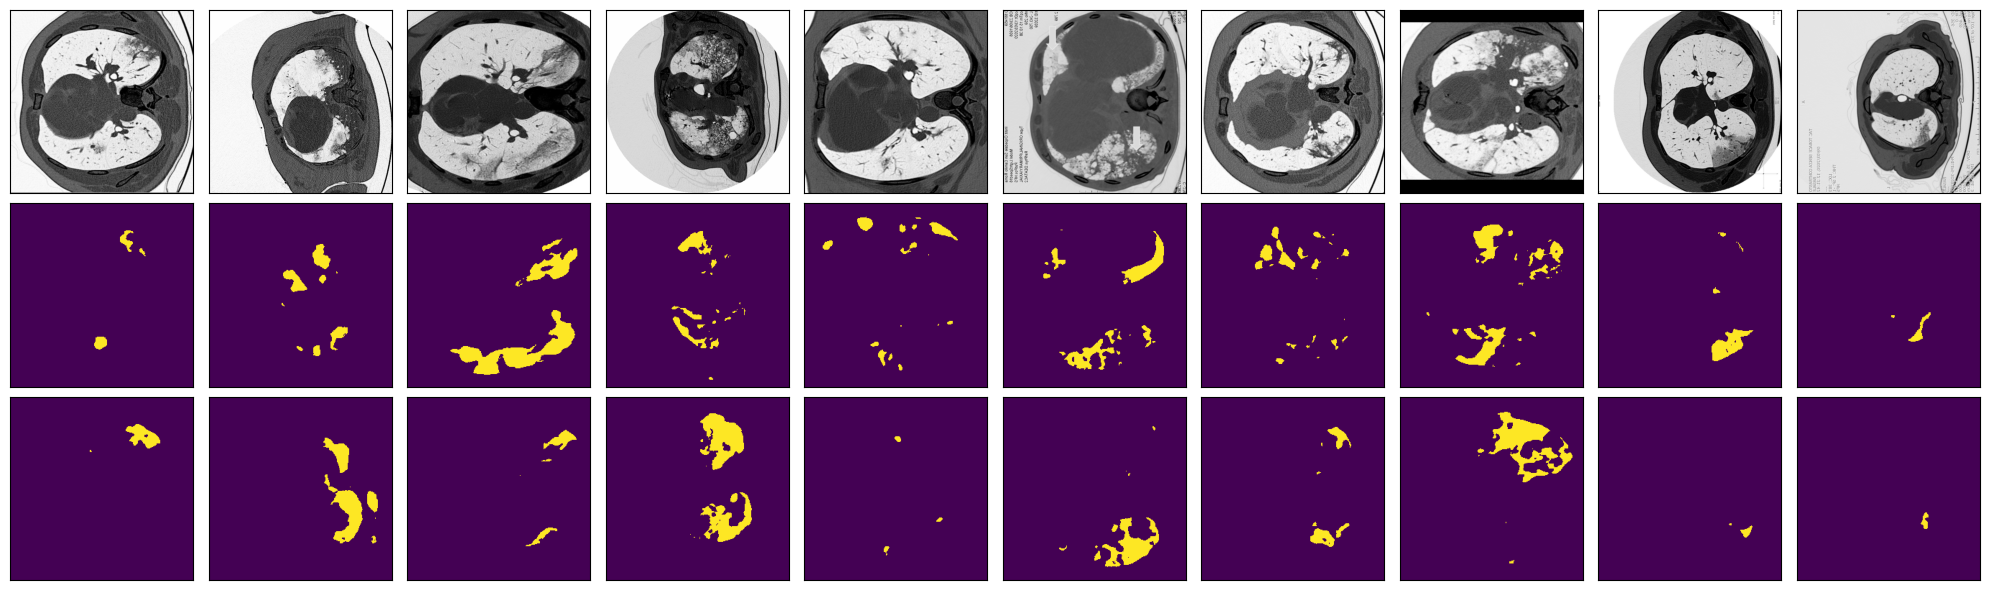

In [25]:
visualize_batch(test_images, preds.transpose(0, 2, 3, 1)[..., :2], num_samples=10)

### Save the submission and upload to Kaggle

In [26]:
import scipy

test_masks_prediction_original_size = scipy.ndimage.zoom(preds.transpose(0, 2, 3, 1)[..., :2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [27]:
import pandas as pd

pd.DataFrame(
    data=np.stack(
        (
            np.arange(len(test_masks_prediction_original_size.ravel())), 
            test_masks_prediction_original_size.ravel().astype(int)
        ),
        axis=-1
    ), 
    columns=[
        'Id', 'Predicted'
    ]
).set_index('Id').to_csv('submission.csv')

In [28]:
! pip install kaggle --quiet

In [29]:
! kaggle competitions submit -c covid-segmentation -f submission.csv -m "AWS submission"

100%|██████████████████████████████████████| 48.9M/48.9M [00:00<00:00, 69.1MB/s]
400 Client Error: Bad Request for url: https://www.kaggle.com/api/v1/competitions/submissions/submit/covid-segmentation
